# Games EDA (Exploratory Data Analysis)

### Directory + install dotenv:

In [1]:
import os
import sys
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)
print("Notebook is using:", sys.executable)
!{sys.executable} -m pip install python-dotenv

Project root: C:\Users\Gebruiker\Documents\SteamRecProject
Notebook is using: c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\python.exe



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports + load

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from src.data.config import PROCESSED_DIR

%matplotlib inline

games_path = PROCESSED_DIR / "games.csv"
games_path

games = pd.read_csv(games_path)
games.head()

games.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067 entries, 0 to 2066
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   appid                2067 non-null   int64  
 1   name                 2067 non-null   object 
 2   type                 2067 non-null   object 
 3   required_age         2067 non-null   int64  
 4   is_free              2067 non-null   bool   
 5   release_date         2034 non-null   object 
 6   coming_soon          2067 non-null   bool   
 7   price_initial        1901 non-null   float64
 8   price_final          1901 non-null   float64
 9   discount_percent     1901 non-null   float64
 10  supported_languages  2066 non-null   object 
 11  genres               2053 non-null   object 
 12  categories           2066 non-null   object 
 13  windows              2067 non-null   bool   
 14  mac                  2067 non-null   bool   
 15  linux                2067 non-null   b

### Filter "real" games and parse dates

In [3]:
# Focus on games only (ignore DLC, software, etc. for now)
games = games[games["type"] == "game"].copy()
games = games.dropna(subset=["name"])

# Parse release_date into datetime and year
games["release_date_parsed"] = pd.to_datetime(
    games["release_date"], errors="coerce"
)
games["release_year"] = games["release_date_parsed"].dt.year

games[["appid", "name", "release_date", "release_year"]].head()

,appid,name,release_date,release_year
0,10,Counter-Strike,"Nov 1, 2000",2000.0
1,20,Team Fortress Classic,"Apr 1, 1999",1999.0
2,30,Day of Defeat,"May 1, 2003",2003.0
3,40,Deathmatch Classic,"Jun 1, 2001",2001.0
4,50,Half-Life: Opposing Force,"Nov 1, 1999",1999.0


### How many games per year?

In [4]:
year_counts = games["release_year"].value_counts().sort_index()

year_counts.tail(20)  # last 20 years (just to see numbers)


release_year
2005.0      6
2006.0     62
2007.0     79
2008.0    145
2009.0    290
2010.0    229
2011.0    242
2012.0    302
2013.0    357
2014.0    164
2015.0     56
2016.0     28
2017.0     16
2018.0     14
2019.0      7
2020.0      5
2021.0      4
2023.0      2
2024.0      3
2025.0      4
Name: count, dtype: int64

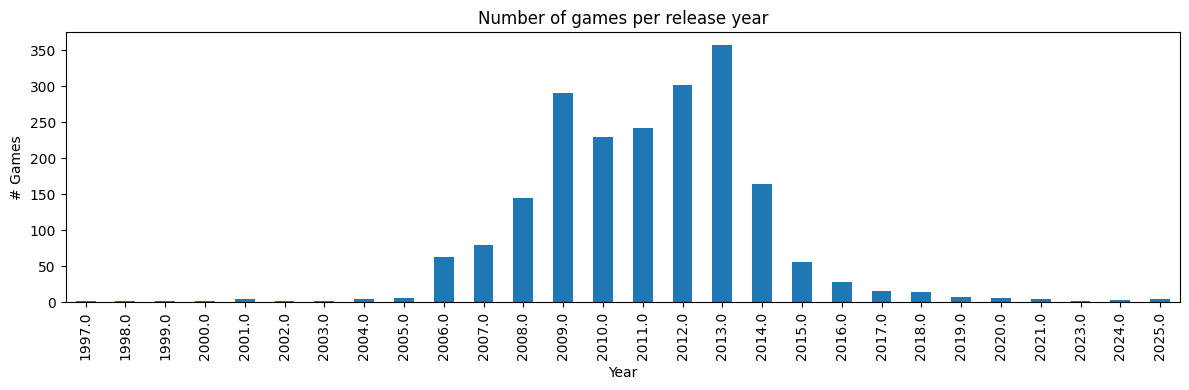

In [5]:
ax = year_counts.plot(
    kind="bar",
    figsize=(12, 4),
    title="Number of games per release year"
)
ax.set_xlabel("Year")
ax.set_ylabel("# Games")
plt.tight_layout()
plt.show()


### Price distribution

In [6]:
priced = games[(games["is_free"] == False) & games["price_final"].notna()].copy()
priced["price_eur"] = priced["price_final"] / 100.0

priced["price_eur"].describe()


count    1901.000000
mean       10.722046
std         7.393647
min         0.540000
25%         4.990000
50%         9.990000
75%        14.990000
max        59.990000
Name: price_eur, dtype: float64

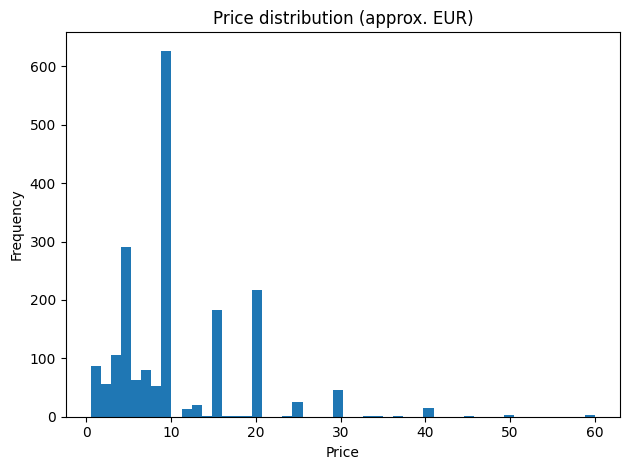

In [7]:
ax = priced["price_eur"].plot(
    kind="hist",
    bins=50,
    title="Price distribution (approx. EUR)"
)
ax.set_xlabel("Price")
plt.tight_layout()
plt.show()


### Genre exploration

In [8]:
def split_semicolon(s):
    if pd.isna(s) or not s:
        return []
    return [t.strip() for t in str(s).split(";") if t.strip()]

all_genres = []
for g in games["genres"]:
    all_genres.extend(split_semicolon(g))

genres_series = pd.Series(all_genres)
top_genres = genres_series.value_counts().head(20)
top_genres


Action                   959
Indie                    863
Adventure                571
Strategy                 542
Casual                   406
RPG                      349
Simulation               296
Free To Play              85
Racing                    82
Massively Multiplayer     51
Sports                    43
Early Access              16
Violent                    1
Nudity                     1
Name: count, dtype: int64

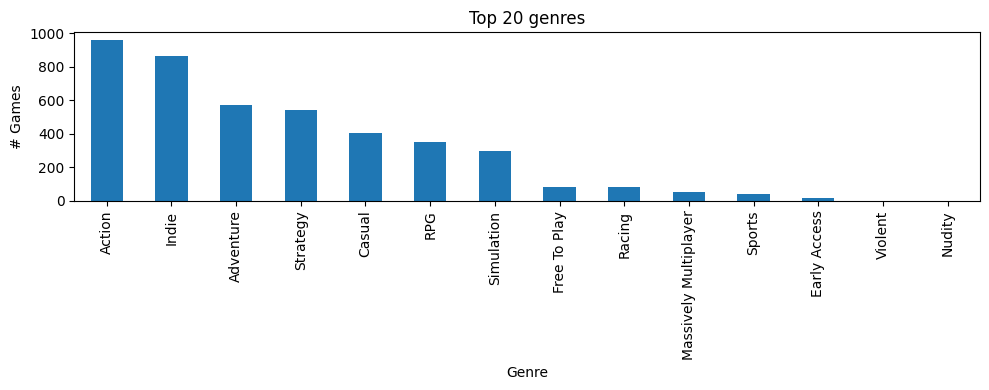

In [9]:
ax = top_genres.plot(
    kind="bar",
    figsize=(10, 4),
    title="Top 20 genres"
)
ax.set_xlabel("Genre")
ax.set_ylabel("# Games")
plt.tight_layout()
plt.show()


### Missing values overview

In [10]:
games.isna().sum().sort_values(ascending=False)


achievements_total     971
metacritic_score       890
price_final            166
price_initial          166
discount_percent       166
release_year            35
release_date_parsed     35
release_date            33
genres                  14
categories               1
supported_languages      1
appid                    0
required_age             0
type                     0
name                     0
coming_soon              0
is_free                  0
linux                    0
windows                  0
mac                      0
dtype: int64

- A lot of games dont have achievements.
- Metacritic score too sparse to rely on too much.

In [11]:
from src.recommender.content_based import ContentBasedRecommender

recommender = ContentBasedRecommender(n_neighbors=200)

games_clean_path = PROCESSED_DIR / "games_clean.csv"
games_clean = pd.read_csv(games_clean_path)

games_clean.sample(5)[["appid", "name", "genres"]]


,appid,name,genres
216,8780,RACE On,Racing
98,3490,Venice Deluxe,Casual
1942,249870,Scribblenauts Unmasked: A DC Comics Adventure,Action;Adventure;Casual;Strategy
489,23600,Depths of Peril,Indie;RPG;Strategy
602,32750,Comanche 4,Action;Simulation


In [12]:
appid_test = 3900
recs = recommender.recommend_similar_by_appid(appid_test, top_n=10)
recs


,appid,name,distance,similarity
0,16810,Sid Meier's Civilization IV: Colonization,0.071397,0.928603
1,22130,Hearts of Iron 2 Complete,0.083811,0.916189
2,9350,Supreme Commander,0.096235,0.903765
3,9420,Supreme Commander: Forged Alliance,0.098274,0.901726
4,3910,Sid Meier's Civilization® III Complete,0.118168,0.881832
5,73170,Darkest Hour: A Hearts of Iron Game,0.128280,0.871720
6,7610,Railroad Tycoon 3,0.128879,0.871121
7,7600,Sid Meier's Railroads!,0.131032,0.868968
8,25830,Knights of Honor,0.131039,0.868961
9,204940,Crusader Kings Complete,0.134660,0.865340
